In [1]:
import numpy as np

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset

from deeptime.data import BaseDataset, UCRDataset
from deeptime.models.representation import ResNetVariationalAutoEncoder

C:\Users\medei\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = UCRDataset(name='FordA', split='train')
len(train_dataset)

3601

In [3]:
test_dataset = UCRDataset(name='FordA', split='test')
len(test_dataset)

1320

In [4]:
unique_labels = torch.unique(train_dataset[:][1])
unique_labels

tensor([-1.,  1.])

In [6]:
for label in unique_labels:
    x_train, y_train = train_dataset[label == train_dataset[:][1]]

    filtered_dataset = BaseDataset(
        x=np.array(x_train.tolist()),
        y=np.array(y_train.tolist())
    )

    train_loader = DataLoader(filtered_dataset, batch_size=16)

    autoencoder = ResNetVariationalAutoEncoder(in_channels=1, mid_channels=64, in_features=500, latent_dim=32)
    trainer = pl.Trainer(
        max_epochs=200,
        accelerator='gpu',
        devices=-1,
        callbacks=[EarlyStopping(monitor='train_loss', mode='min', patience=10, min_delta=1.)]
    )

    trainer.fit(model=autoencoder, train_dataloaders=train_loader)
    break

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | e    | Sequential | 16.9 M
1 | d    | Sequential | 16.8 M
------------------------------------
33.7 M    Trainable params
0         Non-trainable params
33.7 M    Total params
134.878   Total estimated model params size (MB)
C:\Users\medei\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|                                                                                 | 0/116 [00:00<?, ?it/s]

C:\Users\medei\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch 60: 100%|██████████████████████████████████████████████████| 116/116 [00:15<00:00,  7.57it/s, loss=391, v_num=15]


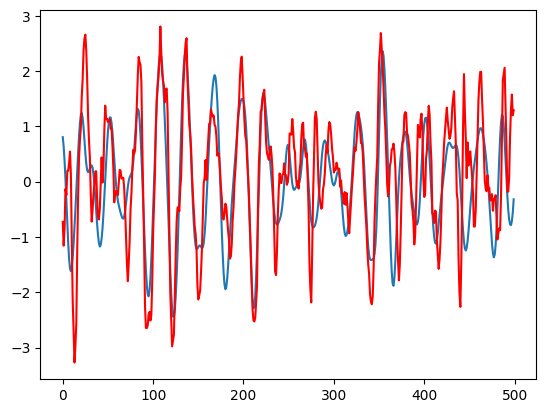

In [8]:
import matplotlib.pyplot as plt

x_hat, _, _ = autoencoder(train_dataset[1:2][0])

plt.plot(list(range(500)), train_dataset[1][0].view(-1).tolist())
plt.plot(list(range(500)), x_hat.view(-1).tolist(), color='red')